In [6]:
from __future__ import annotations

from pathlib import Path
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [7]:
pl.Config.set_tbl_rows(20)
pl.Config.set_tbl_cols(80)
plt.rcParams["figure.figsize"] = (12, 4)

In [8]:
# ---------- Config ----------
ROOT = Path("/media/vatereal/Main/btc_data").resolve()
assert (ROOT / "coingecko").is_dir(), f"ROOT does not look like btc_data (missing coingecko/): {ROOT}"

pl.Config.set_tbl_rows(30)
pl.Config.set_tbl_cols(120)
plt.rcParams["figure.figsize"] = (14, 4)

# include common time names (your files use "time")
TIME_CANDIDATES = ("time", "timestamp", "ts", "snapshot_time", "date", "day", "datetime")

# DAILY-only datasets, PARQUET-only
DATASETS = {
    "spot_daily": [
        "coingecko/market_daily/*.parquet",
    ],
    "ohlc_daily": [
        "coingecko/ohlc_daily_chunks/vs=usd/*.parquet",
    ],
    "exch_vol": [
        "coingecko/exchange_volume_chunks/exchange=*/exchange_volume_*.parquet",
    ],
}

# ---------- Helpers ----------
def resolve_first_matching(root: Path, patterns: list[str]):
    for pat in patterns:
        files = sorted(root.glob(pat))
        if files:
            return pat, files
    return None, []

def scan_parquet_files(files: list[Path], hive_partitioning: bool = True) -> pl.LazyFrame:
    if not files:
        raise ValueError("No parquet files to scan")
    parquet_files = [str(p) for p in files if p.suffix.lower() == ".parquet"]
    if not parquet_files:
        raise ValueError("No parquet files found in file list")
    return pl.scan_parquet(parquet_files, hive_partitioning=hive_partitioning)

def safe_collect(lf: pl.LazyFrame) -> pl.DataFrame:
    """
    Collect without deprecated `streaming=` parameter.
    Prefer streaming engine when supported, otherwise fall back.
    """
    for kwargs in ({"engine": "streaming"}, {"engine": "in-memory"}, {}):
        try:
            return lf.collect(**kwargs)
        except TypeError:
            continue
    return lf.collect()

def lf_schema(lf: pl.LazyFrame) -> pl.Schema:
    # avoids Polars PerformanceWarning from lf.columns / lf.schema
    return lf.collect_schema()

def lf_cols(lf: pl.LazyFrame) -> list[str]:
    return lf_schema(lf).names()

def first_existing_col(cols: list[str], candidates=TIME_CANDIDATES):
    s = set(cols)
    for c in candidates:
        if c in s:
            return c
    return None

def _sample_int_scale(lf: pl.LazyFrame, col: str):
    dtype = lf_schema(lf).get(col)
    if dtype not in (pl.Int64, pl.Int32, pl.UInt64, pl.UInt32):
        return None
    s = safe_collect(lf.select(pl.col(col).drop_nulls().head(25))).get_column(col).to_list()
    if not s:
        return None
    v = max(abs(int(x)) for x in s if x is not None)
    if v >= 10**14:
        return "us"
    if v >= 10**11:
        return "ms"
    return "s"

def normalize_time(lf: pl.LazyFrame, time_col: str, out_col: str = "time") -> pl.LazyFrame:
    """
    Robust time normalization:
    - tz-aware Datetime -> convert to UTC, drop tz
    - tz-naive Datetime -> cast only (no tz ops)
    - epoch ints -> from_epoch
    - strings -> parse with utc=True then drop tz
    """
    schema = lf_schema(lf)
    dtype = schema.get(time_col)
    if dtype is None:
        return lf

    expr = pl.col(time_col)

    if dtype == pl.Date:
        return lf.with_columns(expr.alias(out_col))

    if dtype == pl.Datetime:
        tz = getattr(dtype, "time_zone", None)
        if tz is None:
            expr = expr.cast(pl.Datetime("us"), strict=False)
        else:
            expr = expr.dt.convert_time_zone("UTC").dt.replace_time_zone(None)
        return lf.with_columns(expr.alias(out_col))

    if dtype in (pl.Int64, pl.Int32, pl.UInt64, pl.UInt32):
        unit = _sample_int_scale(lf, time_col) or "s"
        expr = pl.from_epoch(pl.col(time_col), time_unit=unit).dt.replace_time_zone(None)
        return lf.with_columns(expr.alias(out_col))

    if dtype == pl.Utf8:
        expr = expr.str.to_datetime(strict=False, utc=True).dt.replace_time_zone(None)
        return lf.with_columns(expr.alias(out_col))

    expr = expr.cast(pl.Datetime("us"), strict=False)
    return lf.with_columns(expr.alias(out_col))

def load_lf(name: str) -> pl.LazyFrame | None:
    pat, files = resolve_first_matching(ROOT, DATASETS[name])
    if not files:
        return None
    lf = scan_parquet_files(files)
    cols = lf_cols(lf)
    tcol = first_existing_col(cols)
    if tcol:
        lf = normalize_time(lf, tcol, "time")
    return lf

def null_report(lf: pl.LazyFrame, top_n: int = 20) -> pl.DataFrame:
    cols = lf_cols(lf)
    exprs = [(pl.col(c).is_null().sum()).alias(c) for c in cols]
    out = safe_collect(lf.select(exprs))
    long = out.transpose(include_header=True, header_name="column", column_names=["nulls"])
    return long.sort("nulls", descending=True).head(top_n)

def show_schema(name: str, lf: pl.LazyFrame | None):
    if lf is None:
        print(f"\n{name}: MISSING (no parquet files matched)")
        return
    schema = lf_schema(lf)
    cols = schema.names()
    print(f"\n{name}: columns={len(cols)}")
    display(pd.DataFrame({"column": cols, "dtype": [str(schema.get(c)) for c in cols]}))

# ---------- Inventory / profiling ----------
profiles = []
for name, patterns in DATASETS.items():
    pat, files = resolve_first_matching(ROOT, patterns)
    if not files:
        profiles.append({"dataset": name, "pattern": None, "files": 0, "rows": 0, "min_time": None, "max_time": None, "cols": 0})
        continue

    lf = scan_parquet_files(files)
    cols = lf_cols(lf)
    tcol = first_existing_col(cols)

    if tcol:
        lf2 = normalize_time(lf, tcol, "time")
        stats = safe_collect(
            lf2.select(
                pl.len().alias("rows"),
                pl.col("time").min().alias("min_time"),
                pl.col("time").max().alias("max_time"),
            )
        )
        profiles.append({
            "dataset": name,
            "pattern": pat,
            "files": len(files),
            "rows": int(stats["rows"][0]),
            "min_time": stats["min_time"][0],
            "max_time": stats["max_time"][0],
            "cols": len(cols),
        })
    else:
        stats = safe_collect(lf.select(pl.len().alias("rows")))
        profiles.append({"dataset": name, "pattern": pat, "files": len(files), "rows": int(stats["rows"][0]), "min_time": None, "max_time": None, "cols": len(cols)})

profiles_df = pd.DataFrame(profiles).sort_values("dataset")
print("ROOT:", ROOT)
display(profiles_df)

# ---------- Load datasets ----------
spot_daily_lf = load_lf("spot_daily")
ohlc_daily_lf = load_lf("ohlc_daily")
exch_vol_lf   = load_lf("exch_vol")

# Dedupe exchange volume on (exchange,time) if present
if exch_vol_lf is not None:
    vol_cols = set(lf_cols(exch_vol_lf))
    if {"exchange", "time"}.issubset(vol_cols):
        exch_vol_lf = exch_vol_lf.unique(subset=["exchange", "time"], keep="first")

# ---------- Schema peek ----------
show_schema("spot_daily", spot_daily_lf)
show_schema("ohlc_daily", ohlc_daily_lf)
show_schema("exch_vol", exch_vol_lf)

# ---------- Spot daily series + returns + drawdowns + rolling stats ----------
if spot_daily_lf is None:
    raise FileNotFoundError("spot_daily parquet missing (coingecko/market_daily/*.parquet).")

spot_cols = set(lf_cols(spot_daily_lf))
req_spot = {"time", "price"}
if not req_spot.issubset(spot_cols):
    raise ValueError(f"spot_daily missing required columns {req_spot}. Columns: {sorted(list(spot_cols))[:80]}")

# (optional) filter to USD if multiple vs present
if "vs" in spot_cols:
    spot_daily_lf = spot_daily_lf.filter(pl.col("vs") == "usd")

spot_daily_series_lf = (
    spot_daily_lf
    .select([
        pl.col("time").cast(pl.Date).alias("day"),
        pl.col("price").cast(pl.Float64),
    ])
    .group_by("day")
    .agg(pl.last("price").alias("price"))
    .sort("day")
    # returns first
    .with_columns([
        (pl.col("price") / pl.col("price").shift(1)).log().alias("log_ret_1d"),
        (pl.col("price") / pl.col("price").shift(1) - 1.0).alias("ret_1d"),
    ])
    # IMPORTANT: compute peak in its own pass (Polars with_columns is unordered)
    .with_columns([
        pl.col("price").cum_max().alias("peak"),
    ])
    # now peak can be referenced safely
    .with_columns([
        (pl.col("price") / pl.col("peak") - 1.0).alias("drawdown"),
        pl.col("ret_1d").rolling_std(window_size=30).alias("vol_30d"),
        pl.col("price").rolling_mean(window_size=50).alias("sma_50"),
        pl.col("price").rolling_mean(window_size=200).alias("sma_200"),
    ])
)

spot_daily = safe_collect(spot_daily_series_lf)
display(spot_daily.head(10))

print("\nNull report (spot_daily_series):")
display(null_report(spot_daily_series_lf, 15))


ROOT: /media/vatereal/Main/btc_data


,dataset,pattern,files,rows,min_time,max_time,cols
2,exch_vol,coingecko/exchange_volume_chunks/exchange=*/ex...,377,11436,2018-03-09,2025-12-31 23:50:00,4
1,ohlc_daily,coingecko/ohlc_daily_chunks/vs=usd/*.parquet,17,2898,2018-02-09,2025-12-31 00:00:00,7
0,spot_daily,coingecko/market_daily/*.parquet,1,4629,2013-04-28,2025-12-31 00:00:00,6



spot_daily: columns=6


,column,dtype
0,time,"Datetime(time_unit='us', time_zone=None)"
1,price,Float64
2,market_cap,Float64
3,total_volume,Float64
4,vs,String
5,source,String



ohlc_daily: columns=7


,column,dtype
0,open,Float64
1,high,Float64
2,low,Float64
3,close,Float64
4,time,"Datetime(time_unit='us', time_zone=None)"
5,vs,String
6,source,String



exch_vol: columns=4


,column,dtype
0,volume_btc,String
1,time,"Datetime(time_unit='us', time_zone=None)"
2,exchange,String
3,source,String


day,price,log_ret_1d,ret_1d,peak,drawdown,vol_30d,sma_50,sma_200
date,f64,f64,f64,f64,f64,f64,f64,f64
2013-04-28,135.3,null,null,135.3,0.0,null,null,null
2013-04-29,141.96,0.048051,0.049224,141.96,0.0,null,null,null
2013-04-30,135.3,-0.048051,-0.046915,141.96,-0.046915,null,null,null
2013-05-01,117.0,-0.145321,-0.135255,141.96,-0.175824,null,null,null
2013-05-02,103.43,-0.123279,-0.115983,141.96,-0.271414,null,null,null
2013-05-03,91.01,-0.127926,-0.120081,141.96,-0.358904,null,null,null
2013-05-04,111.25,0.200811,0.222393,141.96,-0.216329,null,null,null
2013-05-05,116.79,0.048598,0.049798,141.96,-0.177303,null,null,null
2013-05-06,118.33,0.0131,0.013186,141.96,-0.166455,null,null,null



Null report (spot_daily_series):


column,nulls
str,u32
"""sma_200""",199
"""sma_50""",49
"""vol_30d""",30
"""log_ret_1d""",1
"""ret_1d""",1
"""day""",0
"""price""",0
"""peak""",0
"""drawdown""",0


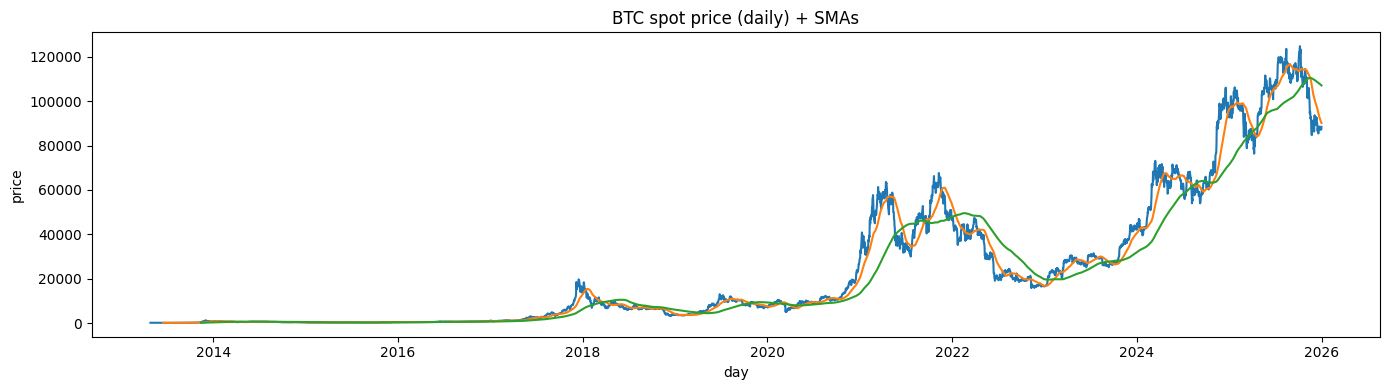

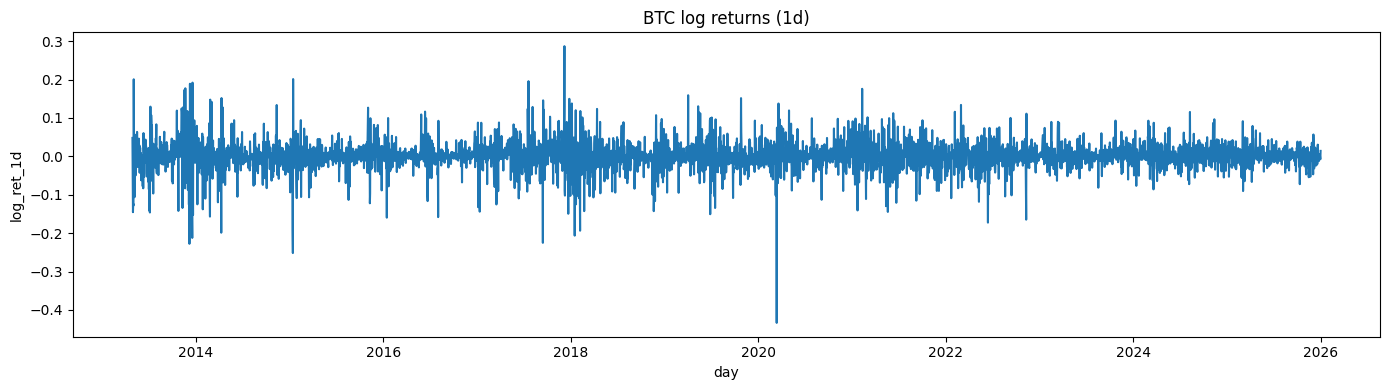

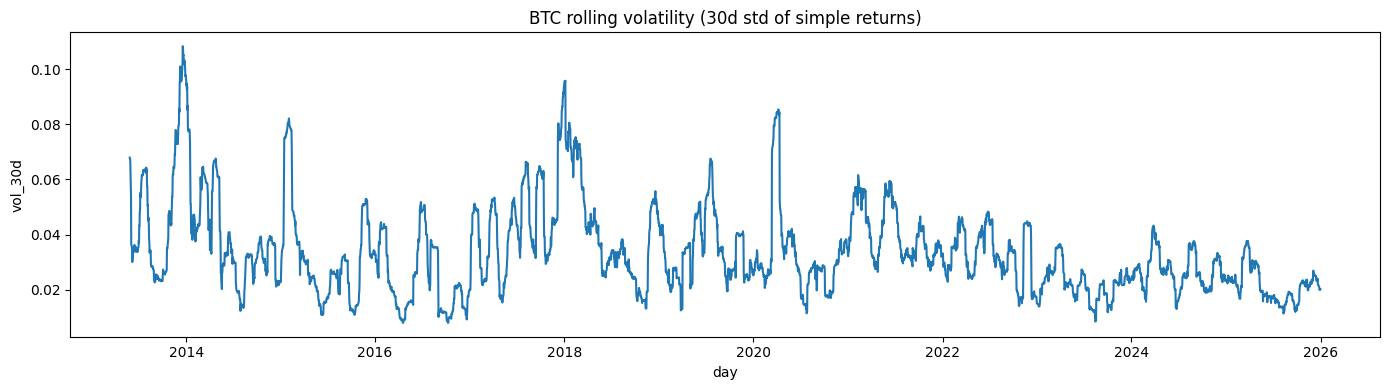

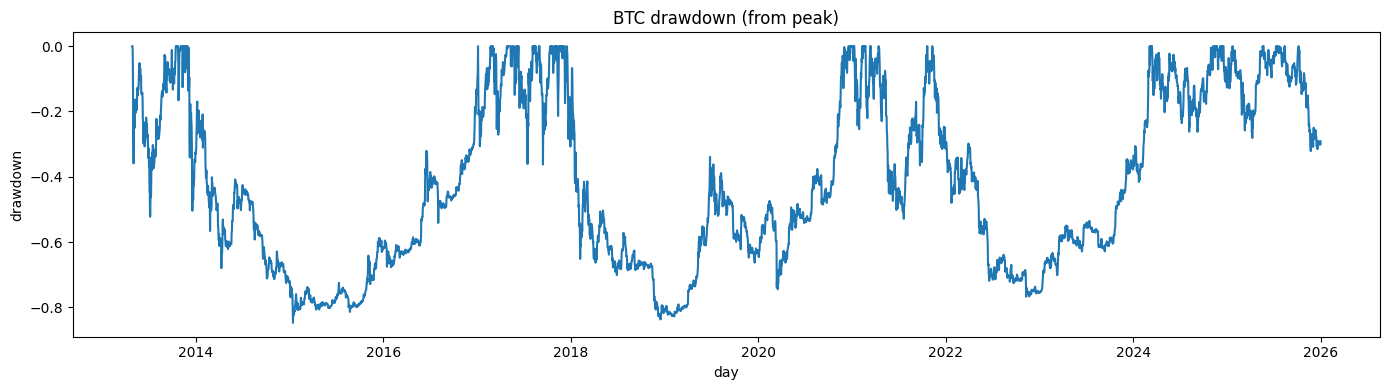

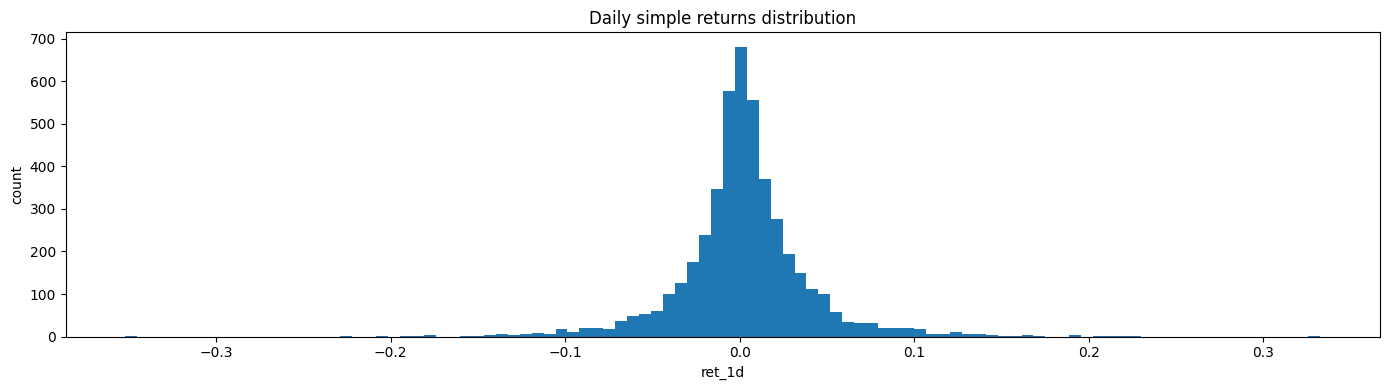

In [9]:
px = spot_daily.select(
    ["day", "price", "log_ret_1d", "ret_1d", "peak", "drawdown", "vol_30d", "sma_50", "sma_200"]
).to_pandas().sort_values("day")

plt.figure()
plt.plot(px["day"], px["price"])
plt.plot(px["day"], px["sma_50"])
plt.plot(px["day"], px["sma_200"])
plt.title("BTC spot price (daily) + SMAs")
plt.xlabel("day"); plt.ylabel("price")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(px["day"], px["log_ret_1d"])
plt.title("BTC log returns (1d)")
plt.xlabel("day"); plt.ylabel("log_ret_1d")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(px["day"], px["vol_30d"])
plt.title("BTC rolling volatility (30d std of simple returns)")
plt.xlabel("day"); plt.ylabel("vol_30d")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(px["day"], px["drawdown"])
plt.title("BTC drawdown (from peak)")
plt.xlabel("day"); plt.ylabel("drawdown")
plt.tight_layout()
plt.show()

ret = px["ret_1d"].dropna()
plt.figure()
plt.hist(ret, bins=100)
plt.title("Daily simple returns distribution")
plt.xlabel("ret_1d"); plt.ylabel("count")
plt.tight_layout()
plt.show()


day,open,high,low,close
date,f64,f64,f64,f64
2018-02-09,7611.61,7611.61,7611.61,7611.61
2018-02-10,8044.31,8674.76,7847.14,8672.57
2018-02-11,8659.92,9088.97,8283.43,8590.21
2018-02-12,8583.38,8583.38,7890.82,8064.69
2018-02-13,8105.98,8920.31,8105.98,8845.22
2018-02-14,8862.71,8884.21,8404.57,8531.09
2018-02-15,8540.3,9451.62,8540.3,9449.7
2018-02-16,9449.93,10144.58,9343.52,10138.05
2018-02-17,10080.49,10274.9,9740.56,10162.74


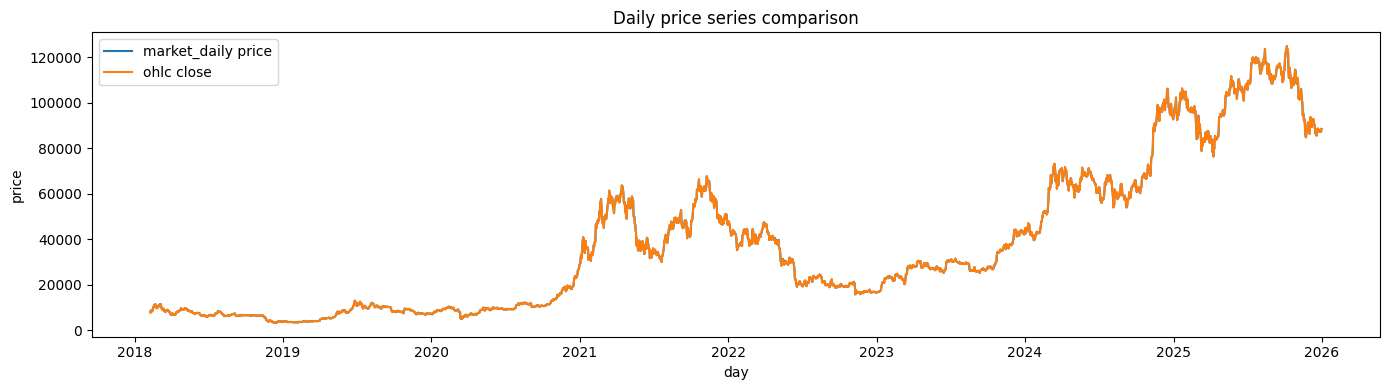

In [ ]:
# ---------- OHLC daily: close vs spot_daily price ----------
if ohlc_daily_lf is not None:
    ohlc_cols = set(lf_cols(ohlc_daily_lf))

    if "vs" in ohlc_cols:
        ohlc_daily_lf = ohlc_daily_lf.filter(pl.col("vs") == "usd")

    need_ohlc = {"time", "open", "high", "low", "close"}
    if not need_ohlc.issubset(ohlc_cols):
        print("\nOHLC daily present but required columns not found:", need_ohlc)
        print("Columns:", sorted(list(ohlc_cols))[:80])
    else:
        ohlc_series_lf = (
            ohlc_daily_lf
            .select([
                pl.col("time").cast(pl.Date).alias("day"),
                pl.col("open").cast(pl.Float64),
                pl.col("high").cast(pl.Float64),
                pl.col("low").cast(pl.Float64),
                pl.col("close").cast(pl.Float64),
            ])
            .group_by("day")
            .agg([
                pl.last("open").alias("open"),
                pl.last("high").alias("high"),
                pl.last("low").alias("low"),
                pl.last("close").alias("close"),
            ])
            .sort("day")
        )

        ohlc = safe_collect(ohlc_series_lf)
        display(ohlc.head(10))

        merged = (
            spot_daily.select(["day", "price"])
            .join(ohlc.select(["day", "close"]), on="day", how="inner")
            .sort("day")
        ).to_pandas()

        plt.figure()
        plt.plot(merged["day"], merged["price"], label="market_daily price")
        plt.plot(merged["day"], merged["close"], label="ohlc close")
        plt.title("Daily price series comparison")
        plt.xlabel("day"); plt.ylabel("price")
        plt.legend()
        plt.tight_layout()
        plt.show()


exchange,day,volume_btc,price,volume_usd
str,date,f64,f64,f64
"""binance""",2018-03-09,161496.961889,9420.85489,1.5214e9
"""binance""",2018-03-10,192548.696353,9276.33759,1.7861e9
"""binance""",2018-03-11,118152.241985,8890.865804,1.0505e9
"""binance""",2018-03-12,121518.756201,9512.456113,1.1559e9
"""binance""",2018-03-13,130850.961668,9232.70588,1.2081e9
"""binance""",2018-03-14,171613.688433,9216.530976,1.5817e9
"""binance""",2018-03-15,173302.754096,8307.223386,1.4397e9
"""binance""",2018-03-16,195183.646673,8359.365283,1.6316e9
"""binance""",2018-03-17,152985.209552,8520.008159,1.3034e9



Top exchanges by total USD volume:


exchange,total_usd
str,f64
"""kraken""",1.2456e16
"""binance""",3.6196e13
"""coinbase-exchange""",5.5516e12
"""bitfinex""",1.2163e12


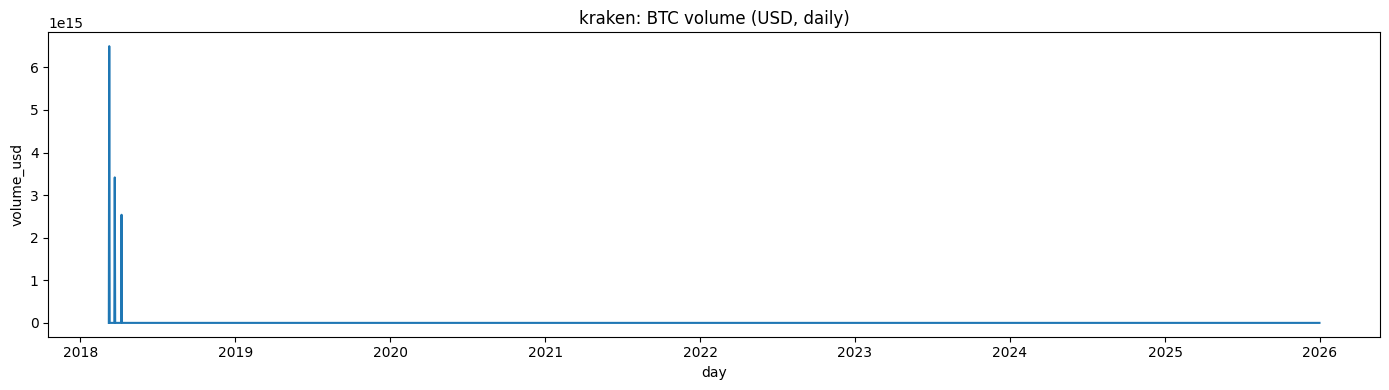

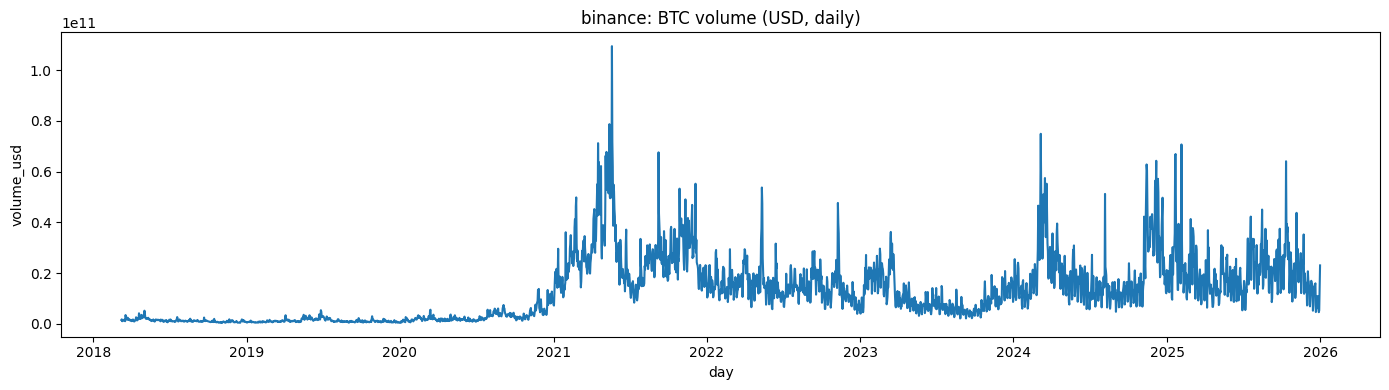

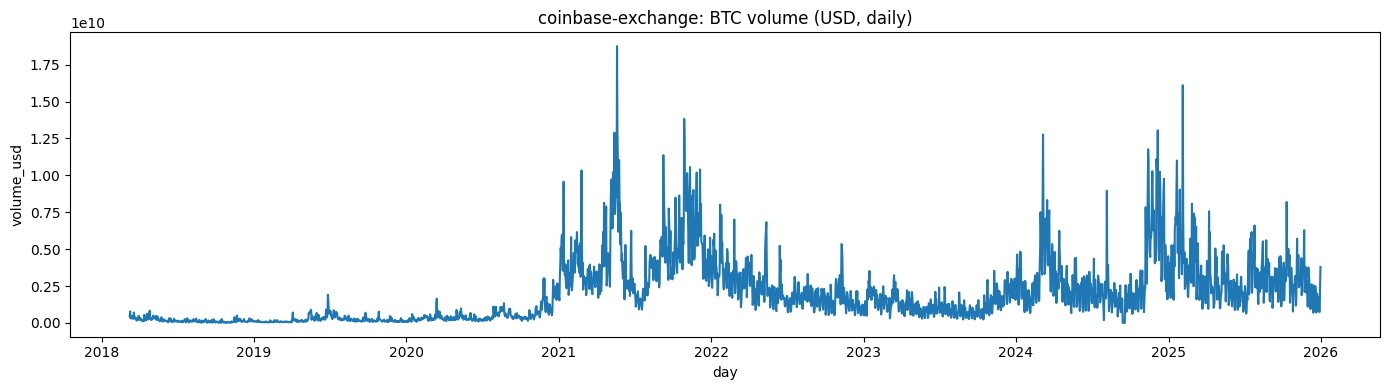

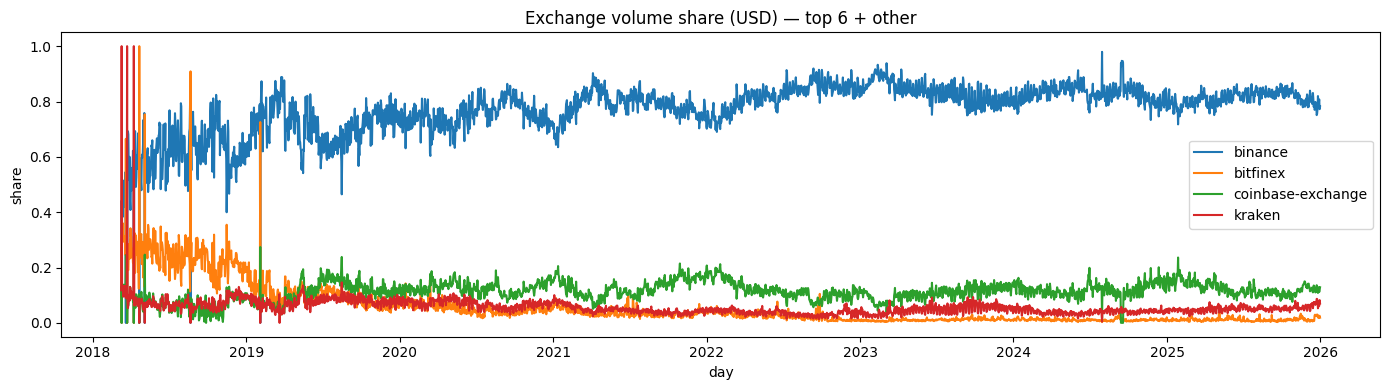

In [ ]:
# ---------- Exchange volume BTC -> USD ----------
if exch_vol_lf is not None:
    vol_cols = set(lf_cols(exch_vol_lf))
    need = {"exchange", "time", "volume_btc"}

    if not need.issubset(vol_cols):
        print("\nExchange volume present, but required columns not found:", need)
        print("Columns:", sorted(list(vol_cols))[:80])
    else:
        # volume_btc is STRING in your parquet -> parse safely
        vol_btc_expr = (
            pl.col("volume_btc")
            .cast(pl.Utf8)
            .str.replace_all(",", "")
            .cast(pl.Float64, strict=False)
            .alias("volume_btc")
        )

        exch_usd_lf = (
            exch_vol_lf
            .select([
                pl.col("exchange"),
                pl.col("time").cast(pl.Date).alias("day"),
                vol_btc_expr,
            ])
            .filter(pl.col("volume_btc").is_not_null())
            .group_by(["exchange", "day"])
            .agg(pl.sum("volume_btc").alias("volume_btc"))
            .join(spot_daily_series_lf.select(["day", "price"]), on="day", how="inner")
            .with_columns((pl.col("volume_btc") * pl.col("price")).alias("volume_usd"))
            .sort(["exchange", "day"])
        )

        exch_usd = safe_collect(exch_usd_lf)
        display(exch_usd.head(10))

        top_ex = safe_collect(
            exch_usd_lf.group_by("exchange")
                       .agg(pl.sum("volume_usd").alias("total_usd"))
                       .sort("total_usd", descending=True)
        )
        print("\nTop exchanges by total USD volume:")
        display(top_ex.head(15))

        # Plot top 3 exchanges volume over time
        top3 = top_ex.select("exchange").head(3).to_series().to_list()
        for ex in top3:
            ex_pd = exch_usd.filter(pl.col("exchange") == ex).select(["day", "volume_usd"]).to_pandas().sort_values("day")
            plt.figure()
            plt.plot(ex_pd["day"], ex_pd["volume_usd"])
            plt.title(f"{ex}: BTC volume (USD, daily)")
            plt.xlabel("day"); plt.ylabel("volume_usd")
            plt.tight_layout()
            plt.show()

        # Market share over time (top N + other)
        topN = 6
        topN_ex = set(top_ex.head(topN)["exchange"].to_list())
        share_lf = (
            exch_usd_lf
            .with_columns(
                pl.when(pl.col("exchange").is_in(list(topN_ex)))
                  .then(pl.col("exchange"))
                  .otherwise(pl.lit("other"))
                  .alias("ex_grp")
            )
            .group_by(["ex_grp", "day"])
            .agg(pl.sum("volume_usd").alias("volume_usd"))
            .sort(["day", "ex_grp"])
        )

        share = safe_collect(share_lf).to_pandas()
        pivot = share.pivot(index="day", columns="ex_grp", values="volume_usd").fillna(0).sort_index()
        frac = pivot.div(pivot.sum(axis=1), axis=0)

        plt.figure()
        for col in frac.columns:
            plt.plot(frac.index, frac[col], label=col)
        plt.title(f"Exchange volume share (USD) — top {topN} + other")
        plt.xlabel("day"); plt.ylabel("share")
        plt.legend()
        plt.tight_layout()
        plt.show()